# Problem Statement
The problem statement is for the data scientist who is working at a home electronics company. He has been asked to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. 
Each gesture corresponds to a specific command:

1.	Thumbs up:  Increase the volume
2.	Thumbs down: Decrease the volume
3.	Left swipe: 'Jump' backwards 10 seconds
4.	Right swipe: 'Jump' forward 10 seconds  
5.	Stop: Pause the movie

The task for the data scientist is to train a model on the 'train' folder (i.e. Training Data) which performs well on the 'val' folder (i.e. Validation Data) as well.

In [24]:
#Importing the required libraries
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [25]:
#Using seed, so that the result don't vary drastically
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [26]:
# Reading the training and val folder names from the csv file
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
#Creating the class with the generator function and other supportive initialization funtions for reusability
class ModelGenerator():
    num_Of_channels=3
    num_Of_classes=5
    
    curr_dt_time = datetime.datetime.now()
    train_path = './Project_data/train'
    val_path = './Project_data/val'
        
    
    # function to set the batch size and epoch
    def set_batch_epoch(self, batch_size=20,num_epochs=10):
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    #function to set the image dimensions
    def image_size_initialize(self,image_height=120,image_width=120):
        self.image_height=image_height
        self.image_width=image_width
     
    #Generator function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.arange(0,30,2)#create a list of image numbers you want to use for a particular video
        num_images=len(img_idx)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size # calculate the number of batches
        
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image_resized=imresize(image,(self.image_height,self.image_width))
                        
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels 
        
            # write the code for the remaining data points which are left after full batches
            if (len(folder_list) != batch_size*num_batches):
                batch_size = len(folder_list) - (batch_size*num_batches)
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image_resized = imresize(image,(self.image_height,self.image_width))
                    
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                   
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels
                
                
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, train_doc,self.batch_size)
        val_generator = self.generator(self.val_path, val_doc, self.batch_size)

        num_train_sequences = len(train_doc)
        #print('# training sequences =', num_train_sequences)
        num_val_sequences = len(val_doc)
        #print('# validation sequences =', num_val_sequences)
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1
    
        #fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history  

### Function to plot the loss and accuracy

In [28]:
# Plotting two plots side by side, one showing the acuracy of train and val data vs epoch and other loss vs epoch
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].set_title("Accuracy VS Epoch Plot")
    axes[0].plot(history.history['categorical_accuracy'])   
    axes[0].plot(history.history['val_categorical_accuracy'])
    axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
      
    axes[1].set_title("Loss VS Epoch Plot")
    axes[1].plot(history.history['loss'])   
    axes[1].plot(history.history['val_loss'])
    axes[1].legend(['loss','val_loss'])
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1: With Dropout in FC only & without Batch Normalization


In [6]:
class Model1_Conv3D_FC(ModelGenerator):
    
    def define_model(self, filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))        
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))


        model.add(Dense(self.num_Of_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

> Image size (120,120)<br>
> Batch Size 10<br>
> Epoch 10<br>
> Filter (3,3,3)

In [7]:
conv_3d_m1=Model1_Conv3D_FC()
conv_3d_m1.image_size_initialize(image_height=120,image_width=120)
conv_3d_m1.set_batch_epoch(batch_size=40,num_epochs=10)
conv_3d_model1=conv_3d_m1.define_model()
conv_3d_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 30, 30, 64)     55360     
__________

In [8]:
print("Total Params:", conv_3d_model1.count_params())
history_model1 = conv_3d_m1.train_model(conv_3d_model1)

Total Params: 2139589
Epoch 1/10
17/17 [==============================] - 156s 9s/step - loss: 1.6166 - categorical_accuracy: 0.2064 - val_loss: 1.6057 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-05-2312_47_51.415740/model-00001-1.61693-0.20513-1.60570-0.18000.h5
Epoch 2/10
17/17 [==============================] - 24s 1s/step - loss: 1.5865 - categorical_accuracy: 0.2251 - val_loss: 1.5264 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-05-2312_47_51.415740/model-00002-1.58649-0.22506-1.52636-0.30000.h5
Epoch 3/10
17/17 [==============================] - 23s 1s/step - loss: 1.4671 - categorical_accuracy: 0.3745 - val_loss: 1.2749 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-05-2312_47_51.415740/model-00003-1.47275-0.37057-1.27494-0.50000.h5
Epoch 4/10
17/17 [==============================] - 19s 1s/step - loss: 1.4650 - categorical_accuracy: 0.3529 - val_loss: 1.2138 - val_categori

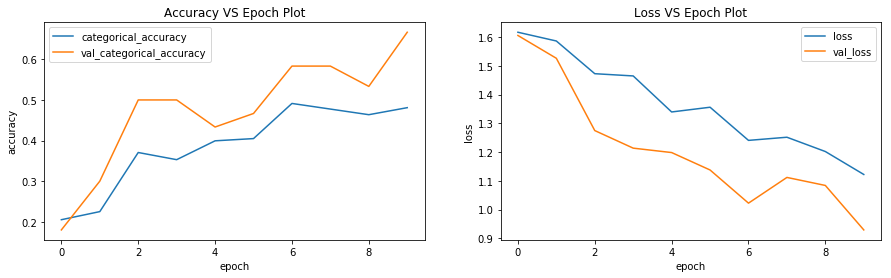

In [9]:
plot(history_model1)

## Model 1-A: With Dropout in FC only & Without BN
> Batch Size 40 <br>
> Epoch 20 <br>
> image size (120,120) <br>
> filterSize: (3,3,3)

In [10]:
conv_3d_m1a=Model1_Conv3D_FC()
conv_3d_m1a.image_size_initialize(image_height=120,image_width=120)
conv_3d_m1a.set_batch_epoch(batch_size=40,num_epochs=20)
conv_3d_model_1a=conv_3d_m1a.define_model()
conv_3d_model_1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 3, 30, 30, 64)     55360     
__________

In [11]:
print("Total Params:", conv_3d_model_1a.count_params())
history_model_1a = conv_3d_m1a.train_model(conv_3d_model_1a)

Total Params: 2139589
Epoch 1/20
17/17 [==============================] - 42s 2s/step - loss: 1.6094 - categorical_accuracy: 0.2064 - val_loss: 1.6065 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-05-2312_53_19.524984/model-00001-1.60957-0.20513-1.60647-0.21000.h5
Epoch 2/20
17/17 [==============================] - 23s 1s/step - loss: 1.5928 - categorical_accuracy: 0.2353 - val_loss: 1.4949 - val_categorical_accuracy: 0.4167

Epoch 00002: saving model to model_init_2020-05-2312_53_19.524984/model-00002-1.59283-0.23529-1.49490-0.41667.h5
Epoch 3/20
17/17 [==============================] - 21s 1s/step - loss: 1.5156 - categorical_accuracy: 0.3407 - val_loss: 1.4237 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2020-05-2312_53_19.524984/model-00003-1.51781-0.34060-1.42375-0.30000.h5
Epoch 4/20
17/17 [==============================] - 19s 1s/step - loss: 1.4205 - categorical_accuracy: 0.3870 - val_loss: 1.3013 - val_categoric

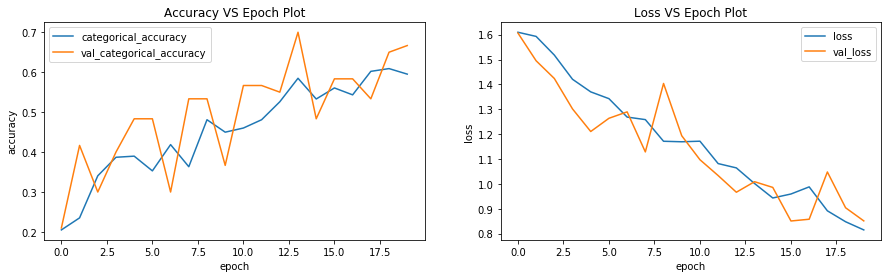

In [12]:
plot(history_model_1a)

## Model 1-B: With Dropout in FC only & Without BN
> Batch Size 30 <br>
> Epoch 20 <br>
> image size (120,120) <br>
> filterSize: (3,3,3)

In [13]:
conv_3d_m1b=Model1_Conv3D_FC()
conv_3d_m1b.image_size_initialize(image_height=120,image_width=120)
conv_3d_m1b.set_batch_epoch(batch_size=30,num_epochs=20)
conv_3d_model_1b=conv_3d_m1b.define_model()
conv_3d_model_1b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_10 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 3, 30, 30, 64)     55360     
__________

In [14]:
print("Total Params:", conv_3d_model_1b.count_params())
history_model_1b = conv_3d_m1b.train_model(conv_3d_model_1b)

Total Params: 2139589
Epoch 1/20
23/23 [==============================] - 42s 2s/step - loss: 1.5877 - categorical_accuracy: 0.2128 - val_loss: 1.5042 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2020-05-2312_59_43.274323/model-00001-1.59254-0.20814-1.50419-0.27000.h5
Epoch 2/20
23/23 [==============================] - 3s 129ms/step - loss: 1.6454 - categorical_accuracy: 0.1739 - val_loss: 1.6079 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2020-05-2312_59_43.274323/model-00002-1.64543-0.17391-1.60789-0.15000.h5
Epoch 3/20
23/23 [==============================] - 5s 201ms/step - loss: 1.6103 - categorical_accuracy: 0.1449 - val_loss: 1.6020 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2020-05-2312_59_43.274323/model-00003-1.61027-0.14493-1.60201-0.25000.h5
Epoch 4/20
23/23 [==============================] - 5s 213ms/step - loss: 1.6171 - categorical_accuracy: 0.1449 - val_loss: 1.6087 - val_cat

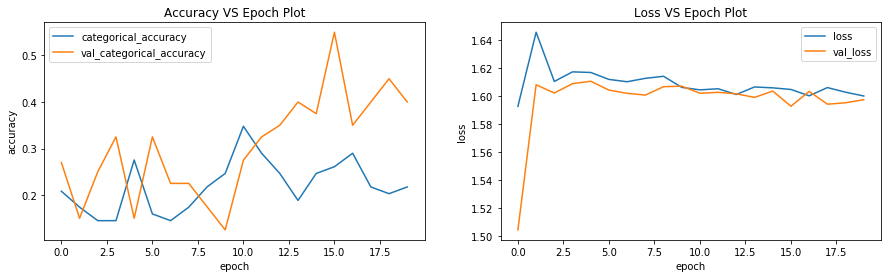

In [15]:
plot(history_model_1b)

## Model 1-C: With Dropout in FC only & Without BN
> Batch Size 50 <br>
> Epoch 20 <br>
> image size (120,120) <br>
> filterSize: (3,3,3)

In [16]:
conv_3d_m1c=Model1_Conv3D_FC()
conv_3d_m1c.image_size_initialize(image_height=120,image_width=120)
conv_3d_m1c.set_batch_epoch(batch_size=50,num_epochs=20)
conv_3d_model_1c=conv_3d_m1c.define_model()
conv_3d_model_1c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_14 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 3, 30, 30, 64)     55360     
__________

In [17]:
print("Total Params:", conv_3d_model_1c.count_params())
history_model_1c = conv_3d_m1c.train_model(conv_3d_model_1c)

Total Params: 2139589
Epoch 1/20
14/14 [==============================] - 47s 3s/step - loss: 1.6492 - categorical_accuracy: 0.2155 - val_loss: 1.6142 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-05-2313_01_52.979526/model-00001-1.65017-0.21870-1.61421-0.18000.h5
Epoch 2/20
14/14 [==============================] - 10s 705ms/step - loss: 1.5951 - categorical_accuracy: 0.2967 - val_loss: 1.5711 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2313_01_52.979526/model-00002-1.59509-0.29670-1.57107-0.25000.h5
Epoch 3/20
14/14 [==============================] - 13s 911ms/step - loss: 1.5862 - categorical_accuracy: 0.2308 - val_loss: 1.4815 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to model_init_2020-05-2313_01_52.979526/model-00003-1.58623-0.23077-1.48151-0.31000.h5
Epoch 4/20
14/14 [==============================] - 11s 818ms/step - loss: 1.5702 - categorical_accuracy: 0.2912 - val_loss: 1.3920 - val_

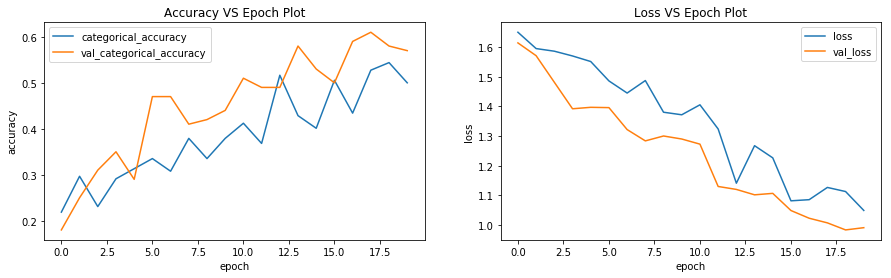

In [18]:
plot(history_model_1c)

## Model 1-D: With Dropout in FC only & Without BN
> Batch Size 70 <br>
> Epoch 30 <br>
> image size (120,120) <br>
> filterSize: (3,3,3)

In [19]:
conv_3d_m1d=Model1_Conv3D_FC()
conv_3d_m1d.image_size_initialize(image_height=120,image_width=120)
conv_3d_m1d.set_batch_epoch(batch_size=70,num_epochs=30)
conv_3d_model_1d=conv_3d_m1d.define_model()
conv_3d_model_1d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_18 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 3, 30, 30, 64)     55360     
__________

In [20]:
print("Total Params:", conv_3d_model_1d.count_params())
history_model_1d = conv_3d_m1d.train_model(conv_3d_model_1d)

Total Params: 2139589
Epoch 1/30
10/10 [==============================] - 43s 4s/step - loss: 1.6154 - categorical_accuracy: 0.2170 - val_loss: 1.6033 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-05-2313_06_30.785072/model-00001-1.61640-0.21418-1.60328-0.21000.h5
Epoch 2/30
10/10 [==============================] - 17s 2s/step - loss: 1.5976 - categorical_accuracy: 0.1879 - val_loss: 1.5402 - val_categorical_accuracy: 0.1833

Epoch 00002: saving model to model_init_2020-05-2313_06_30.785072/model-00002-1.59762-0.18788-1.54018-0.18333.h5
Epoch 3/30
10/10 [==============================] - 18s 2s/step - loss: 1.4859 - categorical_accuracy: 0.2818 - val_loss: 1.3478 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-05-2313_06_30.785072/model-00003-1.48590-0.28182-1.34779-0.45000.h5
Epoch 4/30
10/10 [==============================] - 1s 132ms/step - loss: 1.5171 - categorical_accuracy: 0.2667 - val_loss: 1.6078 - val_categor


Epoch 00028: saving model to model_init_2020-05-2313_06_30.785072/model-00028-1.58720-0.40000-1.61095-0.15000.h5
Epoch 29/30
10/10 [==============================] - 2s 207ms/step - loss: 1.6163 - categorical_accuracy: 0.2333 - val_loss: 1.6100 - val_categorical_accuracy: 0.2000

Epoch 00029: saving model to model_init_2020-05-2313_06_30.785072/model-00029-1.61631-0.23333-1.60995-0.20000.h5
Epoch 30/30
10/10 [==============================] - 2s 210ms/step - loss: 1.6088 - categorical_accuracy: 0.1667 - val_loss: 1.6086 - val_categorical_accuracy: 0.0500

Epoch 00030: saving model to model_init_2020-05-2313_06_30.785072/model-00030-1.60878-0.16667-1.60864-0.05000.h5


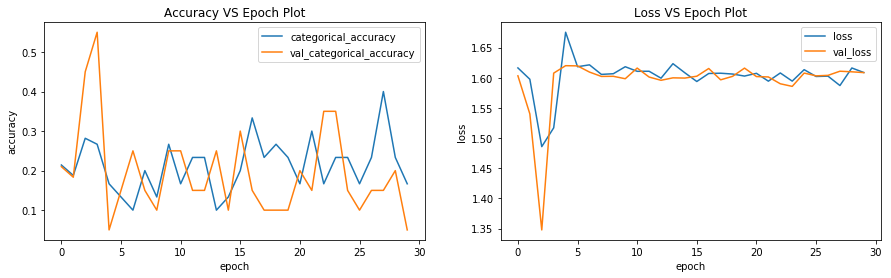

In [21]:
plot(history_model_1d)

## Model 2: With Dropout in Dense Layer & With BN


In [22]:
class Model2_Conv3D_DL_BN(ModelGenerator):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))


        model.add(Dense(self.num_Of_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 2A: With Dropout in dense layer & With BN
> Batch Size 40 <br>
> Epoch 10 <br>
> Image Size (120, 120) <br>
> filterSize: (3,3,3)

In [23]:
conv_3d_m2a=Model2_Conv3D_DL_BN()
conv_3d_m2a.image_size_initialize(image_height=120,image_width=120)
conv_3d_m2a.set_batch_epoch(batch_size=40,num_epochs=10)
conv_3d_model_2a=conv_3d_m2a.define_model()
conv_3d_model_2a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_22 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 60, 60, 32)     128       
__________

In [24]:
print("Total Params:", conv_3d_model_2a.count_params())
history_model_2a = conv_3d_m2a.train_model(conv_3d_model_2a)

Total Params: 2140805
Epoch 1/10
17/17 [==============================] - 42s 2s/step - loss: 1.3381 - categorical_accuracy: 0.4585 - val_loss: 2.5738 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-05-2313_08_48.869541/model-00001-1.34357-0.45701-2.57379-0.45000.h5
Epoch 2/10
17/17 [==============================] - 20s 1s/step - loss: 0.8989 - categorical_accuracy: 0.6471 - val_loss: 1.4037 - val_categorical_accuracy: 0.5833

Epoch 00002: saving model to model_init_2020-05-2313_08_48.869541/model-00002-0.89895-0.64706-1.40367-0.58333.h5
Epoch 3/10
17/17 [==============================] - 22s 1s/step - loss: 0.7694 - categorical_accuracy: 0.7126 - val_loss: 1.4739 - val_categorical_accuracy: 0.5667

Epoch 00003: saving model to model_init_2020-05-2313_08_48.869541/model-00003-0.77906-0.70845-1.47389-0.56667.h5
Epoch 4/10
17/17 [==============================] - 19s 1s/step - loss: 0.5680 - categorical_accuracy: 0.8019 - val_loss: 0.9941 - val_categoric

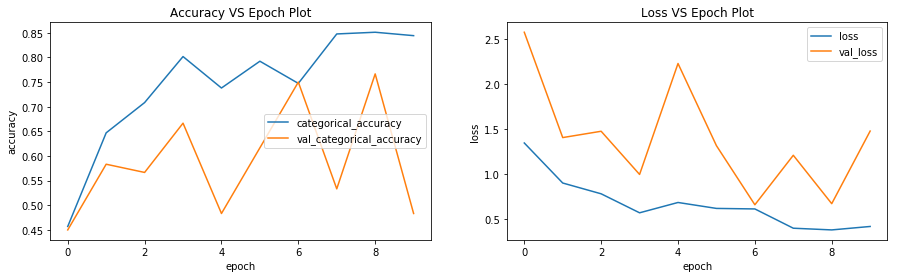

In [25]:
plot(history_model_2a)

## Model 2-B: With Dropout in Dense Layer & With BN
> Batch Size 50 <br>
> Epoch 20 <br>
> Image Size (120, 120) <br>
> filterSize: (3,3,3)

In [26]:
conv_3d_m2b=Model2_Conv3D_DL_BN()
conv_3d_m2b.image_size_initialize(image_height=120,image_width=120)
conv_3d_m2b.set_batch_epoch(batch_size=50,num_epochs=20)
conv_3d_model_2b=conv_3d_m2b.define_model()
conv_3d_model_2b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_26 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 60, 60, 32)     128       
__________

In [27]:
print("Total Params:", conv_3d_model_2b.count_params())
history_model_2b = conv_3d_m2b.train_model(conv_3d_model_2b)

Total Params: 2140805
Epoch 1/20
14/14 [==============================] - 46s 3s/step - loss: 1.5065 - categorical_accuracy: 0.4104 - val_loss: 5.2801 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-05-2313_12_24.522621/model-00001-1.50933-0.41176-5.28009-0.28000.h5
Epoch 2/20
14/14 [==============================] - 10s 728ms/step - loss: 0.9740 - categorical_accuracy: 0.6154 - val_loss: 7.2260 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2313_12_24.522621/model-00002-0.97401-0.61538-7.22596-0.25000.h5
Epoch 3/20
14/14 [==============================] - 12s 869ms/step - loss: 1.1567 - categorical_accuracy: 0.5385 - val_loss: 3.1725 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_init_2020-05-2313_12_24.522621/model-00003-1.15675-0.53846-3.17247-0.37000.h5
Epoch 4/20
14/14 [==============================] - 11s 812ms/step - loss: 0.9711 - categorical_accuracy: 0.5934 - val_loss: 2.6094 - val_

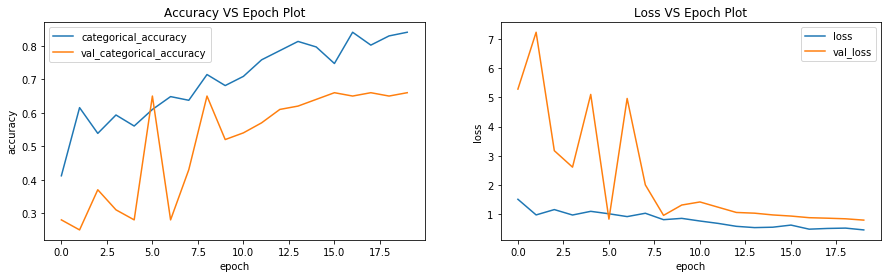

In [28]:
plot(history_model_2b)

## Model 2C: With Dropout in Dense layer & With BN
> Batch Size 50 <br>
> Epoch 40 <br>
> Image Size (120, 120) <br>
> filterSize: (3,3,3)

In [29]:
conv_3d_m2c=Model2_Conv3D_DL_BN()
conv_3d_m2c.image_size_initialize(image_height=120,image_width=120)
conv_3d_m2c.set_batch_epoch(batch_size=50,num_epochs=40)
conv_3d_model_2c=conv_3d_m2c.define_model()
conv_3d_model_2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_30 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 60, 60, 32)     128       
__________

In [30]:
print("Total Params:", conv_3d_model_2c.count_params())
history_model_2c = conv_3d_m2c.train_model(conv_3d_model_2c)

Total Params: 2140805
Epoch 1/40
14/14 [==============================] - 47s 3s/step - loss: 1.3923 - categorical_accuracy: 0.4381 - val_loss: 1.1799 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-05-2313_17_04.567521/model-00001-1.39671-0.43288-1.17988-0.57000.h5
Epoch 2/40
14/14 [==============================] - 9s 627ms/step - loss: 1.1143 - categorical_accuracy: 0.5604 - val_loss: 4.4498 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2313_17_04.567521/model-00002-1.11429-0.56044-4.44979-0.25000.h5
Epoch 3/40
14/14 [==============================] - 12s 879ms/step - loss: 1.0955 - categorical_accuracy: 0.5440 - val_loss: 1.3419 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-05-2313_17_04.567521/model-00003-1.09549-0.54396-1.34193-0.50000.h5
Epoch 4/40
14/14 [==============================] - 13s 894ms/step - loss: 1.0798 - categorical_accuracy: 0.5659 - val_loss: 2.5805 - val_c


Epoch 00029: saving model to model_init_2020-05-2313_17_04.567521/model-00029-0.41454-0.86813-0.56096-0.86000.h5
Epoch 30/40
14/14 [==============================] - 12s 871ms/step - loss: 0.3612 - categorical_accuracy: 0.8846 - val_loss: 0.5615 - val_categorical_accuracy: 0.8600

Epoch 00030: saving model to model_init_2020-05-2313_17_04.567521/model-00030-0.36121-0.88462-0.56152-0.86000.h5
Epoch 31/40
14/14 [==============================] - 13s 904ms/step - loss: 0.3462 - categorical_accuracy: 0.9396 - val_loss: 0.5639 - val_categorical_accuracy: 0.8600

Epoch 00031: saving model to model_init_2020-05-2313_17_04.567521/model-00031-0.34625-0.93956-0.56385-0.86000.h5
Epoch 32/40
14/14 [==============================] - 12s 825ms/step - loss: 0.3355 - categorical_accuracy: 0.8956 - val_loss: 0.5553 - val_categorical_accuracy: 0.8500

Epoch 00032: saving model to model_init_2020-05-2313_17_04.567521/model-00032-0.33554-0.89560-0.55531-0.85000.h5
Epoch 33/40
14/14 [=====================

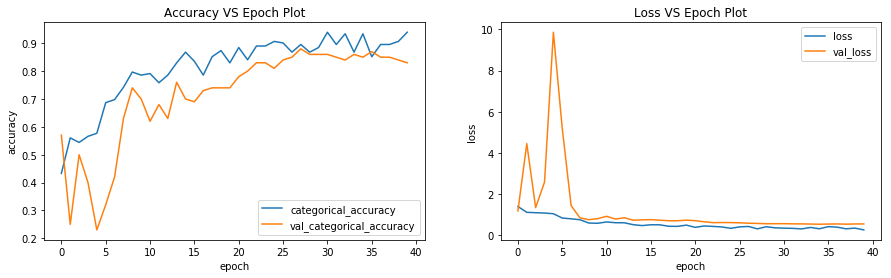

In [31]:
plot(history_model_2c)

## Model 2D: With Dropout in Dense Layer & With BN
> Batch Size 60 <br>
> Epoch 40 <br>
> Image Size (120, 120) <br>
> filterSize: (3,3,3)

In [32]:
conv_3d_m2d=Model2_Conv3D_DL_BN()
conv_3d_m2d.image_size_initialize(image_height=120,image_width=120)
conv_3d_m2d.set_batch_epoch(batch_size=60,num_epochs=40)
conv_3d_model_2d=conv_3d_m2d.define_model()
conv_3d_model_2d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 7, 60, 60, 32)     128       
__________

In [33]:
print("Total Params:", conv_3d_model_2d.count_params())
history_model_2d = conv_3d_m2d.train_model(conv_3d_model_2d)

Total Params: 2140805
Epoch 1/40
12/12 [==============================] - 45s 4s/step - loss: 1.4916 - categorical_accuracy: 0.4144 - val_loss: 2.5084 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-05-2313_25_47.373833/model-00001-1.53079-0.42081-2.50838-0.48000.h5
Epoch 2/40
12/12 [==============================] - 2s 155ms/step - loss: 1.5962 - categorical_accuracy: 0.3889 - val_loss: 9.7682 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2313_25_47.373833/model-00002-1.59615-0.38889-9.76817-0.25000.h5
Epoch 3/40
12/12 [==============================] - 2s 127ms/step - loss: 1.9144 - categorical_accuracy: 0.2500 - val_loss: 10.9000 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2020-05-2313_25_47.373833/model-00003-1.91443-0.25000-10.90002-0.30000.h5
Epoch 4/40
12/12 [==============================] - 3s 240ms/step - loss: 1.7292 - categorical_accuracy: 0.1944 - val_loss: 11.6944 - val_

12/12 [==============================] - 3s 241ms/step - loss: 1.3245 - categorical_accuracy: 0.4444 - val_loss: 1.3154 - val_categorical_accuracy: 0.5000

Epoch 00029: saving model to model_init_2020-05-2313_25_47.373833/model-00029-1.32449-0.44444-1.31543-0.50000.h5
Epoch 30/40
12/12 [==============================] - 3s 259ms/step - loss: 1.4810 - categorical_accuracy: 0.4444 - val_loss: 1.2701 - val_categorical_accuracy: 0.5250

Epoch 00030: saving model to model_init_2020-05-2313_25_47.373833/model-00030-1.48097-0.44444-1.27014-0.52500.h5
Epoch 31/40
12/12 [==============================] - 3s 267ms/step - loss: 1.5566 - categorical_accuracy: 0.3333 - val_loss: 1.4383 - val_categorical_accuracy: 0.3750

Epoch 00031: saving model to model_init_2020-05-2313_25_47.373833/model-00031-1.55658-0.33333-1.43828-0.37500.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 32/40
12/12 [==============================] - 3s 274ms/step - loss: 1.4526 - cate

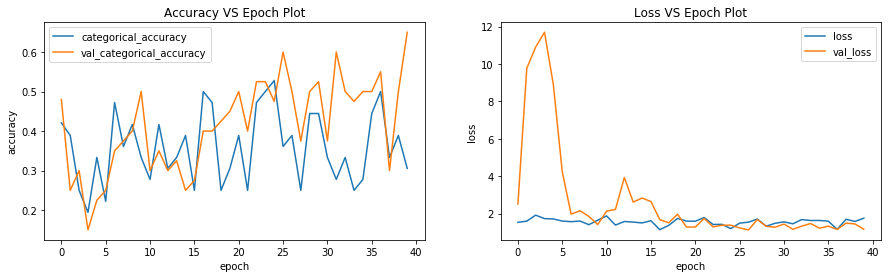

In [34]:
plot(history_model_2d)

## Model 2E: With Dropout  in Dense Layer & With BN
> Batch Size 30 <br>
> Epoch 30 <br>
> Image Size (120, 120) <br>
> filterSize: (3,3,3)

In [35]:
conv_3d_m2e=Model2_Conv3D_DL_BN()
conv_3d_m2e.image_size_initialize(image_height=120,image_width=120)
conv_3d_m2e.set_batch_epoch(batch_size=70,num_epochs=30)
conv_3d_model_2e=conv_3d_m2e.define_model()
conv_3d_model_2e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_38 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 60, 60, 32)     128       
__________

In [36]:
print("Total Params:", conv_3d_model_2e.count_params())
history_model_2e = conv_3d_m2e.train_model(conv_3d_model_2e)

Total Params: 2140805
Epoch 1/30
10/10 [==============================] - 44s 4s/step - loss: 1.4938 - categorical_accuracy: 0.4038 - val_loss: 1.3942 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-05-2313_28_36.707362/model-00001-1.51941-0.39668-1.39425-0.51000.h5
Epoch 2/30
10/10 [==============================] - 16s 2s/step - loss: 0.8341 - categorical_accuracy: 0.6970 - val_loss: 1.2927 - val_categorical_accuracy: 0.5667

Epoch 00002: saving model to model_init_2020-05-2313_28_36.707362/model-00002-0.83409-0.69697-1.29271-0.56667.h5
Epoch 3/30
10/10 [==============================] - 18s 2s/step - loss: 0.9218 - categorical_accuracy: 0.6303 - val_loss: 1.7099 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-05-2313_28_36.707362/model-00003-0.92183-0.63030-1.70986-0.50000.h5
Epoch 4/30
10/10 [==============================] - 2s 162ms/step - loss: 1.5129 - categorical_accuracy: 0.5667 - val_loss: 3.6262 - val_categor

10/10 [==============================] - 2s 217ms/step - loss: 1.5113 - categorical_accuracy: 0.4000 - val_loss: 1.3635 - val_categorical_accuracy: 0.5500

Epoch 00029: saving model to model_init_2020-05-2313_28_36.707362/model-00029-1.51134-0.40000-1.36348-0.55000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 30/30
10/10 [==============================] - 2s 236ms/step - loss: 1.6921 - categorical_accuracy: 0.3667 - val_loss: 1.5828 - val_categorical_accuracy: 0.2500

Epoch 00030: saving model to model_init_2020-05-2313_28_36.707362/model-00030-1.69213-0.36667-1.58275-0.25000.h5


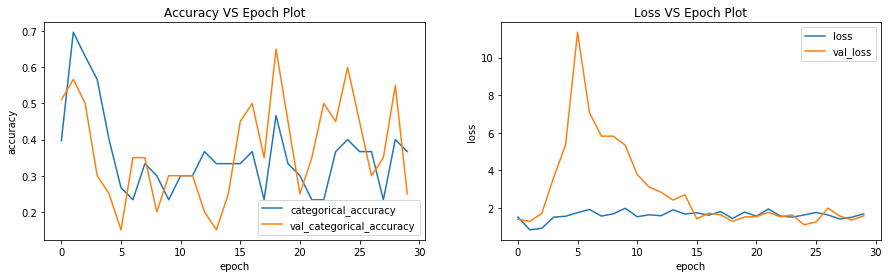

In [37]:
plot(history_model_2e)

## Model 2F: With Dropout in Dense Layer & With BN
> Batch Size 40 <br>
> Epoch 10 <br>
> Image Size (160, 160) <br>
> filterSize: (3,3,3)

In [38]:
conv_3d_m2f=Model2_Conv3D_DL_BN()
conv_3d_m2f.image_size_initialize(image_height=160,image_width=160)
conv_3d_m2f.set_batch_epoch(batch_size=40,num_epochs=20)
conv_3d_model_2f=conv_3d_m2f.define_model()
conv_3d_model_2f.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 7, 80, 80, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 7, 80, 80, 32)     13856     
_________________________________________________________________
activation_42 (Activation)   (None, 7, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 7, 80, 80, 32)     128       
__________

In [39]:
print("Total Params:", conv_3d_model_2f.count_params())
history_model_2f = conv_3d_m2f.train_model(conv_3d_model_2f)

Total Params: 3574405
Epoch 1/20
17/17 [==============================] - 53s 3s/step - loss: 1.5089 - categorical_accuracy: 0.4117 - val_loss: 3.5109 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-05-2313_31_00.417934/model-00001-1.52490-0.40271-3.51093-0.33000.h5
Epoch 2/20
17/17 [==============================] - 20s 1s/step - loss: 1.0480 - categorical_accuracy: 0.6138 - val_loss: 1.2387 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-05-2313_31_00.417934/model-00002-1.04804-0.61381-1.23874-0.55000.h5
Epoch 3/20
17/17 [==============================] - 24s 1s/step - loss: 0.8869 - categorical_accuracy: 0.6156 - val_loss: 1.6355 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-05-2313_31_00.417934/model-00003-0.90022-0.60763-1.63552-0.50000.h5
Epoch 4/20
17/17 [==============================] - 22s 1s/step - loss: 0.9268 - categorical_accuracy: 0.6409 - val_loss: 2.2570 - val_categoric

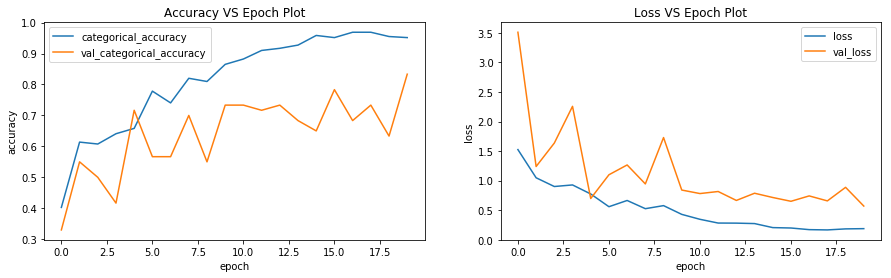

In [40]:
plot(history_model_2f)

## Model 2G: With Dropout in Dense Layer & With BN
> Batch Size 40 <br>
> Epoch 20 <br>
> Image Size (160, 160) <br>
> filterSize: (2,2,2)

In [41]:
conv_3d_m2g=Model2_Conv3D_DL_BN()
conv_3d_m2g.image_size_initialize(image_height=160,image_width=160)
conv_3d_m2g.set_batch_epoch(batch_size=40,num_epochs=20)
conv_3d_model_2g=conv_3d_m2g.define_model()
conv_3d_model_2g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 7, 80, 80, 16)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 7, 80, 80, 32)     13856     
_________________________________________________________________
activation_46 (Activation)   (None, 7, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 7, 80, 80, 32)     128       
__________

In [42]:
print("Total Params:", conv_3d_model_2g.count_params())
history_model_2g = conv_3d_m2g.train_model(conv_3d_model_2g)

Total Params: 3574405
Epoch 1/20
17/17 [==============================] - 51s 3s/step - loss: 1.4083 - categorical_accuracy: 0.4208 - val_loss: 5.6752 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-05-2313_38_26.957541/model-00001-1.41829-0.41629-5.67522-0.29000.h5
Epoch 2/20
17/17 [==============================] - 21s 1s/step - loss: 0.9782 - categorical_accuracy: 0.5934 - val_loss: 2.0601 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-05-2313_38_26.957541/model-00002-0.97824-0.59335-2.06007-0.55000.h5
Epoch 3/20
17/17 [==============================] - 24s 1s/step - loss: 0.9300 - categorical_accuracy: 0.6054 - val_loss: 1.8501 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-05-2313_38_26.957541/model-00003-0.93194-0.60490-1.85011-0.45000.h5
Epoch 4/20
17/17 [==============================] - 22s 1s/step - loss: 1.0902 - categorical_accuracy: 0.5851 - val_loss: 7.7729 - val_categoric

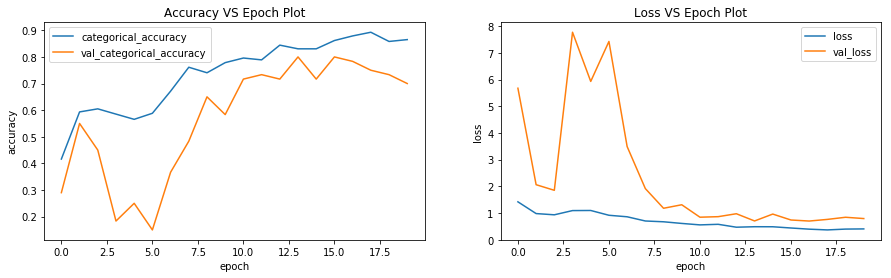

In [43]:
plot(history_model_2g)

## Model 2H: With Dropout in Dense Layer & With BN
> Batch Size 40 <br>
> Epoch 20 <br>
> Image Size (120, 120) <br>
> filterSize: (2,2,2)

In [44]:
conv_3d_m2h=Model2_Conv3D_DL_BN()
conv_3d_m2h.image_size_initialize(image_height=120,image_width=120)
conv_3d_m2h.set_batch_epoch(batch_size=40,num_epochs=20)
conv_3d_model_2h=conv_3d_m2h.define_model()
conv_3d_model_2h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_50 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 7, 60, 60, 32)     128       
__________

In [45]:
print("Total Params:", conv_3d_model_2h.count_params())
history_model_2h = conv_3d_m2h.train_model(conv_3d_model_2h)

Total Params: 2140805
Epoch 1/20
17/17 [==============================] - 43s 3s/step - loss: 1.5102 - categorical_accuracy: 0.4178 - val_loss: 4.2957 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-05-2313_45_57.957056/model-00001-1.51591-0.41629-4.29573-0.33000.h5
Epoch 2/20
17/17 [==============================] - 17s 982ms/step - loss: 1.0432 - categorical_accuracy: 0.6036 - val_loss: 4.8283 - val_categorical_accuracy: 0.3167

Epoch 00002: saving model to model_init_2020-05-2313_45_57.957056/model-00002-1.04321-0.60358-4.82827-0.31667.h5
Epoch 3/20
17/17 [==============================] - 21s 1s/step - loss: 0.9435 - categorical_accuracy: 0.6475 - val_loss: 4.1832 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2020-05-2313_45_57.957056/model-00003-0.95346-0.64305-4.18316-0.35000.h5
Epoch 4/20
17/17 [==============================] - 19s 1s/step - loss: 0.7881 - categorical_accuracy: 0.7059 - val_loss: 3.5093 - val_catego

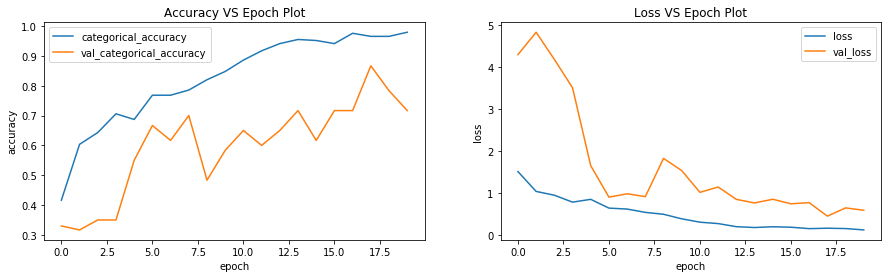

In [46]:
plot(history_model_2h)

## Model 3 :- Withouth Dropout & with BN


In [47]:
class Model3_Conv3D_BN(ModelGenerator):
    
    def define_model(self, filtersize=(3,3,3),dense_neurons=64):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))        
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))

        #Flatten layer
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        
        model.add(Dense(dense_neurons,activation='relu'))
       
        #Softmax layer
        model.add(Dense(self.num_Of_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 3A :- Without Dropout with BN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 10<br>
> Filter (3,3,3)


In [48]:
conv_3d_m3a=Model3_Conv3D_BN()
conv_3d_m3a.image_size_initialize(image_height=120,image_width=120)
conv_3d_m3a.set_batch_epoch(batch_size=40,num_epochs=10)
conv_3d_model_3a=conv_3d_m3a.define_model()
conv_3d_model_3a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_54 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 3, 30, 30, 64)     55360     
__________

In [49]:
print("Total Params:", conv_3d_model_3a.count_params())
history_model_3a = conv_3d_m3a.train_model(conv_3d_model_3a)

Total Params: 2139589
Epoch 1/10
17/17 [==============================] - 41s 2s/step - loss: 1.5750 - categorical_accuracy: 0.2163 - val_loss: 1.6190 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-05-2313_52_16.706689/model-00001-1.57650-0.21418-1.61903-0.29000.h5
Epoch 2/10
17/17 [==============================] - 19s 1s/step - loss: 1.5243 - categorical_accuracy: 0.2916 - val_loss: 1.4546 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-05-2313_52_16.706689/model-00002-1.52428-0.29156-1.45460-0.40000.h5
Epoch 3/10
17/17 [==============================] - 21s 1s/step - loss: 1.4122 - categorical_accuracy: 0.3623 - val_loss: 1.4708 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2020-05-2313_52_16.706689/model-00003-1.41431-0.36512-1.47081-0.25000.h5
Epoch 4/10
17/17 [==============================] - 19s 1s/step - loss: 1.3574 - categorical_accuracy: 0.4180 - val_loss: 1.2494 - val_categoric

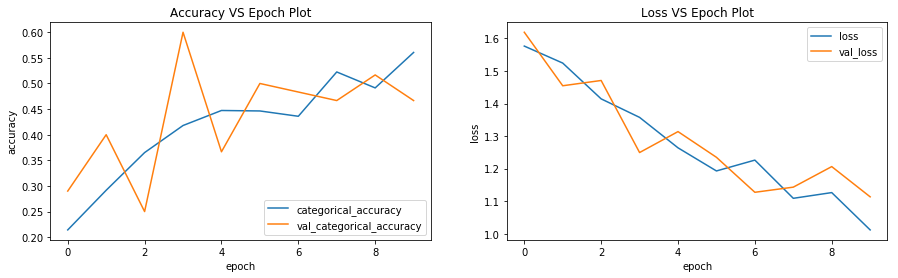

In [50]:
plot(history_model_3a)

## Model 3B :- Withouth Dropout & With BN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 50<br>
> Filter (3,3,3)

In [51]:
conv_3d_m3b=Model3_Conv3D_BN()
conv_3d_m3b.image_size_initialize(image_height=120,image_width=120)
conv_3d_m3b.set_batch_epoch(batch_size=40,num_epochs=50)
conv_3d_model_3b=conv_3d_m3b.define_model()
conv_3d_model_3b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_57 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_58 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 3, 30, 30, 64)     55360     
__________

In [52]:
print("Total Params:", conv_3d_model_3b.count_params())
history_model_3b = conv_3d_m3b.train_model(conv_3d_model_3b)

Total Params: 2139589
Epoch 1/50
17/17 [==============================] - 42s 2s/step - loss: 1.6214 - categorical_accuracy: 0.2235 - val_loss: 1.5606 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-05-2313_55_46.747363/model-00001-1.62177-0.22474-1.56056-0.23000.h5
Epoch 2/50
17/17 [==============================] - 19s 1s/step - loss: 1.5508 - categorical_accuracy: 0.2916 - val_loss: 1.5118 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2020-05-2313_55_46.747363/model-00002-1.55081-0.29156-1.51177-0.45000.h5
Epoch 3/50
17/17 [==============================] - 21s 1s/step - loss: 1.4514 - categorical_accuracy: 0.3289 - val_loss: 1.3705 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-05-2313_55_46.747363/model-00003-1.45574-0.32698-1.37053-0.40000.h5
Epoch 4/50
17/17 [==============================] - 19s 1s/step - loss: 1.3011 - categorical_accuracy: 0.4520 - val_loss: 1.0932 - val_categoric

17/17 [==============================] - 18s 1s/step - loss: 0.6086 - categorical_accuracy: 0.7543 - val_loss: 0.7348 - val_categorical_accuracy: 0.7000

Epoch 00029: saving model to model_init_2020-05-2313_55_46.747363/model-00029-0.60864-0.75433-0.73484-0.70000.h5
Epoch 30/50
17/17 [==============================] - 17s 984ms/step - loss: 0.6132 - categorical_accuracy: 0.7543 - val_loss: 0.9869 - val_categorical_accuracy: 0.6000

Epoch 00030: saving model to model_init_2020-05-2313_55_46.747363/model-00030-0.61318-0.75433-0.98695-0.60000.h5
Epoch 31/50
17/17 [==============================] - 17s 972ms/step - loss: 0.5922 - categorical_accuracy: 0.7612 - val_loss: 0.7556 - val_categorical_accuracy: 0.6833

Epoch 00031: saving model to model_init_2020-05-2313_55_46.747363/model-00031-0.59219-0.76125-0.75559-0.68333.h5
Epoch 32/50
17/17 [==============================] - 18s 1s/step - loss: 0.5911 - categorical_accuracy: 0.7543 - val_loss: 0.7846 - val_categorical_accuracy: 0.6500

Epo

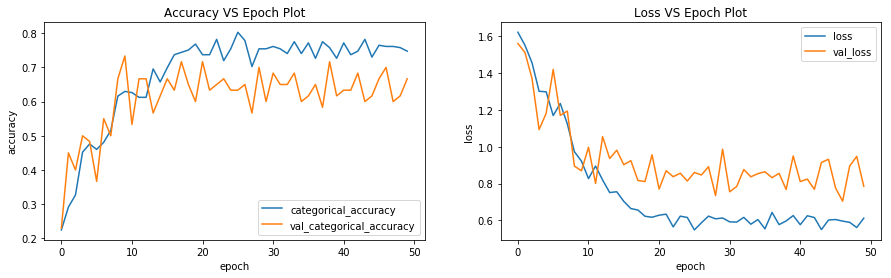

In [53]:
plot(history_model_3b)

## Model 4 :- With Dropout in FC Layer & With BN


In [54]:
class Model4_Conv3D_FC_BN(ModelGenerator):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        #Flatten layer
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        # Softmax layer
        model.add(Dense(self.num_Of_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 4A :- With Dropout in FC layer & With BN
> Image size (120,120)<br>
> Batch Size 30<br>
> Epoch 50<br>
> Filter (3,3,3)

In [55]:
conv_3d_m4a=Model4_Conv3D_FC_BN()
conv_3d_m4a.image_size_initialize(image_height=120,image_width=120)
conv_3d_m4a.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_4a=conv_3d_m4a.define_model()
conv_3d_model_4a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_46 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_62 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 7, 60, 60, 32)     128       
__________

In [56]:
print("Total Params:", conv_3d_model_4a.count_params())
history_model_4a = conv_3d_m4a.train_model(conv_3d_model_4a)

Total Params: 2140805
Epoch 1/30
17/17 [==============================] - 43s 3s/step - loss: 1.4217 - categorical_accuracy: 0.4149 - val_loss: 3.1578 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-05-2314_10_45.490467/model-00001-1.43302-0.41026-3.15778-0.32000.h5
Epoch 2/30
17/17 [==============================] - 17s 1s/step - loss: 0.9768 - categorical_accuracy: 0.5985 - val_loss: 1.8502 - val_categorical_accuracy: 0.3667

Epoch 00002: saving model to model_init_2020-05-2314_10_45.490467/model-00002-0.97677-0.59847-1.85017-0.36667.h5
Epoch 3/30
17/17 [==============================] - 21s 1s/step - loss: 0.8604 - categorical_accuracy: 0.6536 - val_loss: 2.9673 - val_categorical_accuracy: 0.2333

Epoch 00003: saving model to model_init_2020-05-2314_10_45.490467/model-00003-0.87073-0.64850-2.96731-0.23333.h5
Epoch 4/30
17/17 [==============================] - 20s 1s/step - loss: 0.7055 - categorical_accuracy: 0.7492 - val_loss: 0.8908 - val_categoric


Epoch 00029: saving model to model_init_2020-05-2314_10_45.490467/model-00029-0.11559-0.97232-0.53646-0.81667.h5
Epoch 30/30
17/17 [==============================] - 16s 941ms/step - loss: 0.0817 - categorical_accuracy: 0.9827 - val_loss: 0.5523 - val_categorical_accuracy: 0.8167

Epoch 00030: saving model to model_init_2020-05-2314_10_45.490467/model-00030-0.08167-0.98270-0.55228-0.81667.h5


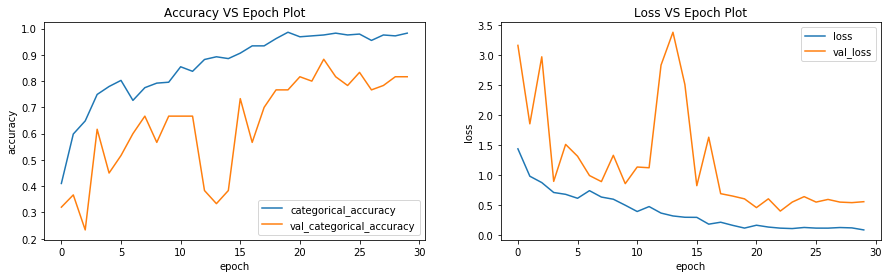

In [57]:
plot(history_model_4a)

## Model 4B :- With Dropout in FC layer & With BN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 60<br>
> Filter (3,3,3)

In [100]:
conv_3d_m4b=Model4_Conv3D_FC_BN()
conv_3d_m4b.image_size_initialize(image_height=120,image_width=120)
conv_3d_m4b.set_batch_epoch(batch_size=40,num_epochs=60)
conv_3d_model_4b=conv_3d_m4b.define_model(dropout=.5)
conv_3d_model_4b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_108 (Conv3D)          (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_108 (Activation)  (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_79 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_109 (Activation)  (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 7, 60, 60, 32)     128       
__________

In [59]:
print("Total Params:", conv_3d_model_4b.count_params())
history_model_4b = conv_3d_m4b.train_model(conv_3d_model_4b)

Total Params: 2140805
Epoch 1/60
17/17 [==============================] - 41s 2s/step - loss: 1.7556 - categorical_accuracy: 0.3750 - val_loss: 3.5530 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-05-2314_19_53.985705/model-00001-1.76975-0.37255-3.55301-0.35000.h5
Epoch 2/60
17/17 [==============================] - 16s 961ms/step - loss: 1.5606 - categorical_accuracy: 0.4246 - val_loss: 8.2654 - val_categorical_accuracy: 0.1833

Epoch 00002: saving model to model_init_2020-05-2314_19_53.985705/model-00002-1.56059-0.42455-8.26539-0.18333.h5
Epoch 3/60
17/17 [==============================] - 20s 1s/step - loss: 1.5143 - categorical_accuracy: 0.4284 - val_loss: 10.5955 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2020-05-2314_19_53.985705/model-00003-1.52028-0.42507-10.59555-0.25000.h5
Epoch 4/60
17/17 [==============================] - 19s 1s/step - loss: 1.4639 - categorical_accuracy: 0.4056 - val_loss: 8.0860 - val_cate

17/17 [==============================] - 17s 984ms/step - loss: 0.6378 - categorical_accuracy: 0.7578 - val_loss: 0.6259 - val_categorical_accuracy: 0.8333

Epoch 00057: saving model to model_init_2020-05-2314_19_53.985705/model-00057-0.63778-0.75779-0.62590-0.83333.h5
Epoch 58/60
17/17 [==============================] - 17s 998ms/step - loss: 0.7243 - categorical_accuracy: 0.7197 - val_loss: 0.6687 - val_categorical_accuracy: 0.8333

Epoch 00058: saving model to model_init_2020-05-2314_19_53.985705/model-00058-0.72433-0.71972-0.66871-0.83333.h5
Epoch 59/60
17/17 [==============================] - 17s 1s/step - loss: 0.7040 - categorical_accuracy: 0.7647 - val_loss: 0.5413 - val_categorical_accuracy: 0.8667

Epoch 00059: saving model to model_init_2020-05-2314_19_53.985705/model-00059-0.70400-0.76471-0.54128-0.86667.h5
Epoch 60/60
17/17 [==============================] - 17s 1s/step - loss: 0.6726 - categorical_accuracy: 0.7336 - val_loss: 0.6597 - val_categorical_accuracy: 0.8167

Epo

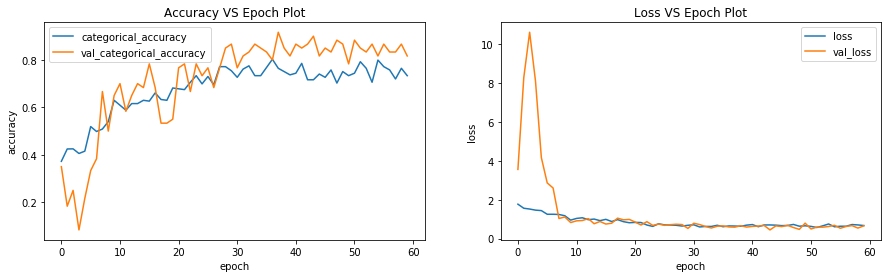

In [60]:
plot(history_model_4b)

## Model 4C :- With dropout in FC layer & With BN
> Image size (100,100)<br>
> Batch Size 40<br>
> Epoch 50<br>
> Filter (3,3,3)<br>
> dense neurons 128
> dropout 0.4


In [102]:
conv_3d_m4c=Model4_Conv3D_FC_BN()
conv_3d_m4c.image_size_initialize(image_height=100,image_width=100)
conv_3d_m4c.set_batch_epoch(batch_size=40,num_epochs=50)
conv_3d_model_4c=conv_3d_m4c.define_model(dropout=.40, dense_neurons=128)
conv_3d_model_4c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_116 (Conv3D)          (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_116 (Activation)  (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_85 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_117 (Conv3D)          (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_117 (Activation)  (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 7, 50, 50, 32)     128       
__________

In [62]:
print("Total Params:", conv_3d_model_4c.count_params())
history_model_4c = conv_3d_m4c.train_model(conv_3d_model_4c)

Total Params: 2669893
Epoch 1/50
17/17 [==============================] - 43s 3s/step - loss: 1.6460 - categorical_accuracy: 0.4138 - val_loss: 2.7147 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-05-2314_37_39.353954/model-00001-1.65429-0.41327-2.71471-0.46000.h5
Epoch 2/50
17/17 [==============================] - 15s 856ms/step - loss: 1.1326 - categorical_accuracy: 0.5985 - val_loss: 2.5753 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-05-2314_37_39.353954/model-00002-1.13258-0.59847-2.57525-0.55000.h5
Epoch 3/50
17/17 [==============================] - 20s 1s/step - loss: 1.1224 - categorical_accuracy: 0.5859 - val_loss: 2.7737 - val_categorical_accuracy: 0.5167

Epoch 00003: saving model to model_init_2020-05-2314_37_39.353954/model-00003-1.13572-0.58038-2.77368-0.51667.h5
Epoch 4/50
17/17 [==============================] - 18s 1s/step - loss: 0.9320 - categorical_accuracy: 0.6625 - val_loss: 1.0098 - val_catego


Epoch 00029: saving model to model_init_2020-05-2314_37_39.353954/model-00029-0.30540-0.89965-0.50828-0.80000.h5
Epoch 30/50
17/17 [==============================] - 16s 940ms/step - loss: 0.3306 - categorical_accuracy: 0.8685 - val_loss: 0.4802 - val_categorical_accuracy: 0.8333

Epoch 00030: saving model to model_init_2020-05-2314_37_39.353954/model-00030-0.33058-0.86851-0.48024-0.83333.h5
Epoch 31/50
17/17 [==============================] - 16s 949ms/step - loss: 0.2987 - categorical_accuracy: 0.8789 - val_loss: 0.5870 - val_categorical_accuracy: 0.7833

Epoch 00031: saving model to model_init_2020-05-2314_37_39.353954/model-00031-0.29871-0.87889-0.58700-0.78333.h5
Epoch 32/50
17/17 [==============================] - 17s 993ms/step - loss: 0.2539 - categorical_accuracy: 0.9135 - val_loss: 0.4868 - val_categorical_accuracy: 0.8167

Epoch 00032: saving model to model_init_2020-05-2314_37_39.353954/model-00032-0.25395-0.91349-0.48682-0.81667.h5

Epoch 00032: ReduceLROnPlateau reducing

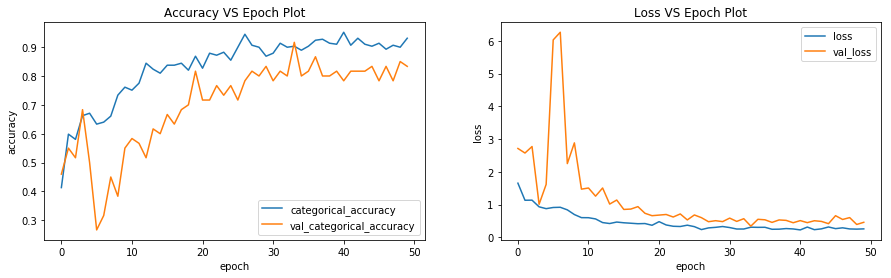

In [63]:
plot(history_model_4c)

## Model 4D :- With dropout in FC Layer & With BN
> Image size (160,160)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> Dense neurons = 256<br>
> dropout 0.5

In [64]:
conv_3d_m4d=Model4_Conv3D_FC_BN()
conv_3d_m4d.image_size_initialize(image_height=160,image_width=160)
conv_3d_m4d.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_4d=conv_3d_m4d.define_model(dense_neurons=256,dropout=0.5)
conv_3d_model_4d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_73 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_73 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_55 (MaxPooling (None, 7, 80, 80, 16)     0         
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 7, 80, 80, 32)     13856     
_________________________________________________________________
activation_74 (Activation)   (None, 7, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 7, 80, 80, 32)     128       
__________

In [65]:
print("Total Params:", conv_3d_model_4d.count_params())
history_model_4d = conv_3d_m4d.train_model(conv_3d_model_4d)

Total Params: 13468357
Epoch 1/30
17/17 [==============================] - 51s 3s/step - loss: 1.7604 - categorical_accuracy: 0.4032 - val_loss: 2.4705 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-05-2314_52_09.305063/model-00001-1.77779-0.39819-2.47052-0.44000.h5
Epoch 2/30
17/17 [==============================] - 18s 1s/step - loss: 1.2150 - categorical_accuracy: 0.5473 - val_loss: 6.2353 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2314_52_09.305063/model-00002-1.21497-0.54731-6.23527-0.25000.h5
Epoch 3/30
17/17 [==============================] - 24s 1s/step - loss: 1.2195 - categorical_accuracy: 0.5515 - val_loss: 1.7939 - val_categorical_accuracy: 0.5167

Epoch 00003: saving model to model_init_2020-05-2314_52_09.305063/model-00003-1.23014-0.54768-1.79389-0.51667.h5
Epoch 4/30
17/17 [==============================] - 22s 1s/step - loss: 1.0994 - categorical_accuracy: 0.5789 - val_loss: 1.9545 - val_categori


Epoch 00029: saving model to model_init_2020-05-2314_52_09.305063/model-00029-0.27682-0.90657-0.56423-0.81667.h5
Epoch 30/30
17/17 [==============================] - 19s 1s/step - loss: 0.2008 - categorical_accuracy: 0.9343 - val_loss: 0.6020 - val_categorical_accuracy: 0.8833

Epoch 00030: saving model to model_init_2020-05-2314_52_09.305063/model-00030-0.20075-0.93426-0.60200-0.88333.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


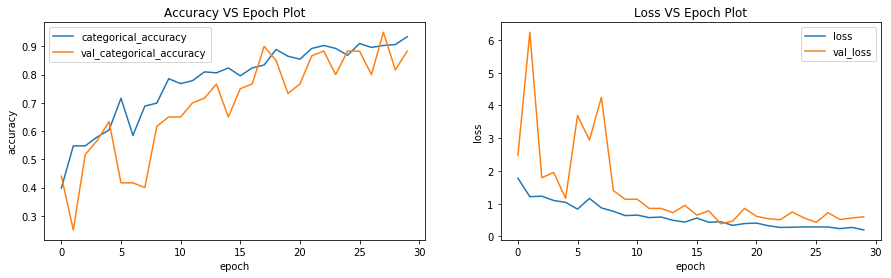

In [66]:
plot(history_model_4d)

## Model 4E :- With dropout in FC layer and with BN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> Dense neurons = 128<br>
> dropout 0.5

In [67]:
conv_3d_m4e=Model4_Conv3D_FC_BN()
conv_3d_m4e.image_size_initialize(image_height=120,image_width=120)
conv_3d_m4e.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_4e=conv_3d_m4e.define_model(dense_neurons=128,dropout=0.5)
conv_3d_model_4e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_77 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_77 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_58 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_78 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 7, 60, 60, 32)     128       
__________

In [68]:
print("Total Params:", conv_3d_model_4e.count_params())
history_model_4e = conv_3d_m4e.train_model(conv_3d_model_4e)

Total Params: 3996997
Epoch 1/30
17/17 [==============================] - 43s 3s/step - loss: 1.8731 - categorical_accuracy: 0.3661 - val_loss: 4.0461 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-05-2315_02_51.598239/model-00001-1.87960-0.36652-4.04609-0.39000.h5
Epoch 2/30
17/17 [==============================] - 15s 867ms/step - loss: 1.3609 - categorical_accuracy: 0.5115 - val_loss: 11.1186 - val_categorical_accuracy: 0.1667

Epoch 00002: saving model to model_init_2020-05-2315_02_51.598239/model-00002-1.36091-0.51151-11.11863-0.16667.h5
Epoch 3/30
17/17 [==============================] - 22s 1s/step - loss: 1.5555 - categorical_accuracy: 0.4546 - val_loss: 10.6565 - val_categorical_accuracy: 0.2333

Epoch 00003: saving model to model_init_2020-05-2315_02_51.598239/model-00003-1.55728-0.45504-10.65646-0.23333.h5
Epoch 4/30
17/17 [==============================] - 19s 1s/step - loss: 1.4552 - categorical_accuracy: 0.4892 - val_loss: 6.2639 - val_ca

17/17 [==============================] - 17s 972ms/step - loss: 0.5228 - categorical_accuracy: 0.7958 - val_loss: 0.6442 - val_categorical_accuracy: 0.7833

Epoch 00029: saving model to model_init_2020-05-2315_02_51.598239/model-00029-0.52280-0.79585-0.64420-0.78333.h5
Epoch 30/30
17/17 [==============================] - 17s 1s/step - loss: 0.5591 - categorical_accuracy: 0.8201 - val_loss: 0.6572 - val_categorical_accuracy: 0.8167

Epoch 00030: saving model to model_init_2020-05-2315_02_51.598239/model-00030-0.55907-0.82007-0.65723-0.81667.h5


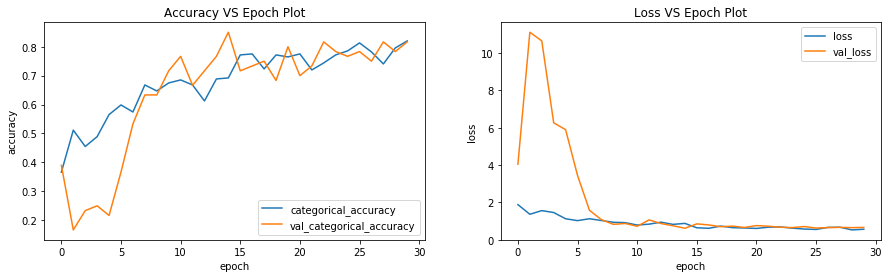

In [69]:
plot(history_model_4e)

## Model 4F :- Without dropout in FC layer and with BN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> Dense neurons = 128

In [70]:
conv_3d_m4f=Model4_Conv3D_FC_BN()
conv_3d_m4f.image_size_initialize(image_height=120,image_width=120)
conv_3d_m4f.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_4f=conv_3d_m4f.define_model(dense_neurons=128)
conv_3d_model_4f.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_81 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_81 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_82 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 7, 60, 60, 32)     128       
__________

In [71]:
print("Total Params:", conv_3d_model_4f.count_params())
history_model_4f = conv_3d_m4f.train_model(conv_3d_model_4f)

Total Params: 3996997
Epoch 1/30
17/17 [==============================] - 43s 3s/step - loss: 1.3420 - categorical_accuracy: 0.4937 - val_loss: 1.7519 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-05-2315_12_03.692332/model-00001-1.35798-0.48567-1.75185-0.53000.h5
Epoch 2/30
17/17 [==============================] - 16s 959ms/step - loss: 0.8396 - categorical_accuracy: 0.6880 - val_loss: 1.0563 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-05-2315_12_03.692332/model-00002-0.83962-0.68798-1.05630-0.60000.h5
Epoch 3/30
17/17 [==============================] - 21s 1s/step - loss: 0.7668 - categorical_accuracy: 0.7173 - val_loss: 1.3300 - val_categorical_accuracy: 0.5333

Epoch 00003: saving model to model_init_2020-05-2315_12_03.692332/model-00003-0.77941-0.71390-1.32998-0.53333.h5
Epoch 4/30
17/17 [==============================] - 19s 1s/step - loss: 0.7114 - categorical_accuracy: 0.7740 - val_loss: 1.5739 - val_catego

17/17 [==============================] - 18s 1s/step - loss: 0.0682 - categorical_accuracy: 0.9965 - val_loss: 0.5890 - val_categorical_accuracy: 0.7833

Epoch 00029: saving model to model_init_2020-05-2315_12_03.692332/model-00029-0.06818-0.99654-0.58897-0.78333.h5
Epoch 30/30
17/17 [==============================] - 17s 973ms/step - loss: 0.0687 - categorical_accuracy: 0.9862 - val_loss: 0.5524 - val_categorical_accuracy: 0.7833

Epoch 00030: saving model to model_init_2020-05-2315_12_03.692332/model-00030-0.06870-0.98616-0.55236-0.78333.h5


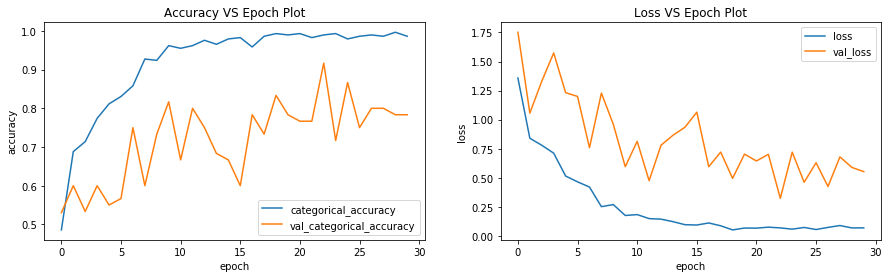

In [72]:
plot(history_model_4f)

## Model 4G :- With dropout in FC layer and with BN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> dropout 0.5

In [73]:
conv_3d_m4g=Model4_Conv3D_FC_BN()
conv_3d_m4g.image_size_initialize(image_height=120,image_width=120)
conv_3d_m4g.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_4g=conv_3d_m4g.define_model(dropout=0.5)
conv_3d_model_4g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_85 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_85 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_64 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_86 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 7, 60, 60, 32)     128       
__________

In [74]:
print("Total Params:", conv_3d_model_4g.count_params())
history_model_4g = conv_3d_m4g.train_model(conv_3d_model_4g)

Total Params: 2140805
Epoch 1/30
17/17 [==============================] - 44s 3s/step - loss: 2.0326 - categorical_accuracy: 0.3014 - val_loss: 2.9414 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-05-2315_21_22.230866/model-00001-2.03818-0.29713-2.94141-0.37000.h5
Epoch 2/30
17/17 [==============================] - 15s 861ms/step - loss: 1.6105 - categorical_accuracy: 0.3887 - val_loss: 2.6637 - val_categorical_accuracy: 0.3833

Epoch 00002: saving model to model_init_2020-05-2315_21_22.230866/model-00002-1.61053-0.38875-2.66369-0.38333.h5
Epoch 3/30
17/17 [==============================] - 21s 1s/step - loss: 1.4193 - categorical_accuracy: 0.4392 - val_loss: 2.6863 - val_categorical_accuracy: 0.4833

Epoch 00003: saving model to model_init_2020-05-2315_21_22.230866/model-00003-1.42779-0.43869-2.68628-0.48333.h5
Epoch 4/30
17/17 [==============================] - 19s 1s/step - loss: 1.4354 - categorical_accuracy: 0.4427 - val_loss: 4.9907 - val_catego

17/17 [==============================] - 16s 962ms/step - loss: 0.5893 - categorical_accuracy: 0.7439 - val_loss: 0.7237 - val_categorical_accuracy: 0.7000

Epoch 00030: saving model to model_init_2020-05-2315_21_22.230866/model-00030-0.58930-0.74394-0.72368-0.70000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


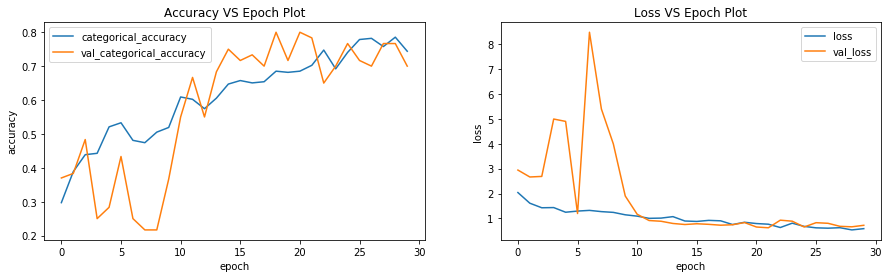

In [75]:
plot(history_model_4g)


## Model 5: Adding one more convulotion layer

In [76]:
class Model5_Conv3D_1CNLayer(ModelGenerator):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, filtersize, padding='same', input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_Of_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 5A :- With dropout in FC layer and with BN (With Extra layers)
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> dropout 0.5

In [77]:
conv_3d_m5a=Model5_Conv3D_1CNLayer()
conv_3d_m5a.image_size_initialize(image_height=120,image_width=120)
conv_3d_m5a.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_5a=conv_3d_m5a.define_model(dropout=0.5)
conv_3d_model_5a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_89 (Conv3D)           (None, 15, 120, 120, 8)   656       
_________________________________________________________________
activation_89 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 15, 120, 120, 16)  3472      
_________________________________________________________________
activation_90 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_67 (MaxPooling (None, 7, 60, 60, 16)     0         
__________

In [78]:
print("Total Params:", conv_3d_model_5a.count_params())
history_model_5a = conv_3d_m5a.train_model(conv_3d_model_5a)

Total Params: 2143909
Epoch 1/30
17/17 [==============================] - 49s 3s/step - loss: 2.0979 - categorical_accuracy: 0.3004 - val_loss: 8.4081 - val_categorical_accuracy: 0.1100

Epoch 00001: saving model to model_init_2020-05-2315_30_43.968926/model-00001-2.11117-0.29713-8.40811-0.11000.h5
Epoch 2/30
17/17 [==============================] - 18s 1s/step - loss: 1.6734 - categorical_accuracy: 0.4169 - val_loss: 2.5655 - val_categorical_accuracy: 0.2667

Epoch 00002: saving model to model_init_2020-05-2315_30_43.968926/model-00002-1.67343-0.41688-2.56552-0.26667.h5
Epoch 3/30
17/17 [==============================] - 19s 1s/step - loss: 1.6632 - categorical_accuracy: 0.4115 - val_loss: 1.6293 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-05-2315_30_43.968926/model-00003-1.65428-0.41417-1.62930-0.45000.h5
Epoch 4/30
17/17 [==============================] - 17s 1s/step - loss: 1.4661 - categorical_accuracy: 0.4427 - val_loss: 3.8463 - val_categoric

17/17 [==============================] - 17s 1s/step - loss: 0.6273 - categorical_accuracy: 0.7682 - val_loss: 0.6654 - val_categorical_accuracy: 0.8167

Epoch 00030: saving model to model_init_2020-05-2315_30_43.968926/model-00030-0.62727-0.76817-0.66544-0.81667.h5


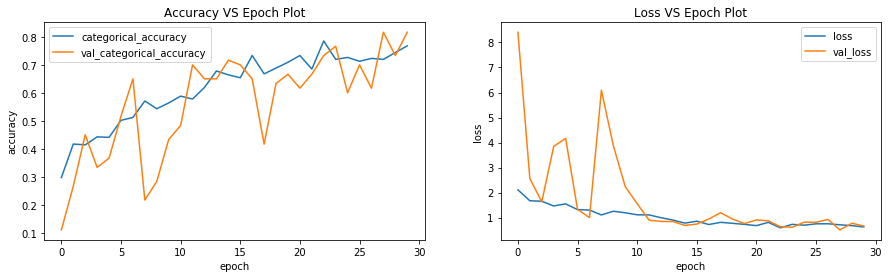

In [79]:
plot(history_model_5a)

## Model 5B :- With dropout in FC layer and with BN (With Extra layers)
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> dropout 0.25

In [80]:
conv_3d_m5b=Model5_Conv3D_1CNLayer()
conv_3d_m5b.image_size_initialize(image_height=120,image_width=120)
conv_3d_m5b.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_5b=conv_3d_m5b.define_model()
conv_3d_model_5b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_94 (Conv3D)           (None, 15, 120, 120, 8)   656       
_________________________________________________________________
activation_94 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 15, 120, 120, 16)  3472      
_________________________________________________________________
activation_95 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_70 (MaxPooling (None, 7, 60, 60, 16)     0         
__________

In [81]:
print("Total Params:", conv_3d_model_5b.count_params())
history_model_5b = conv_3d_m5b.train_model(conv_3d_model_5b)

Total Params: 2143909
Epoch 1/30
17/17 [==============================] - 46s 3s/step - loss: 1.6182 - categorical_accuracy: 0.4001 - val_loss: 3.4042 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-05-2315_40_17.802378/model-00001-1.62548-0.39819-3.40422-0.31000.h5
Epoch 2/30
17/17 [==============================] - 18s 1s/step - loss: 1.2325 - categorical_accuracy: 0.5320 - val_loss: 1.4854 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-05-2315_40_17.802378/model-00002-1.23246-0.53197-1.48536-0.50000.h5
Epoch 3/30
17/17 [==============================] - 17s 983ms/step - loss: 0.9538 - categorical_accuracy: 0.6454 - val_loss: 2.5553 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-05-2315_40_17.802378/model-00003-0.96145-0.64305-2.55534-0.50000.h5
Epoch 4/30
17/17 [==============================] - 18s 1s/step - loss: 0.8936 - categorical_accuracy: 0.6378 - val_loss: 0.9132 - val_catego

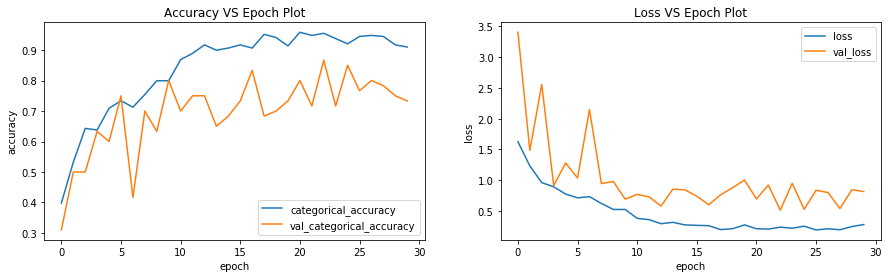

In [82]:
plot(history_model_5b)

## Model 5C :- With dropout in FC layer and with BN (With Extra layers)
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)<br>
> dropout 0.4

In [83]:
conv_3d_m5c=Model5_Conv3D_1CNLayer()
conv_3d_m5c.image_size_initialize(image_height=120,image_width=120)
conv_3d_m5c.set_batch_epoch(batch_size=40,num_epochs=30)
conv_3d_model_5c=conv_3d_m5c.define_model(dropout=0.40)
conv_3d_model_5c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_99 (Conv3D)           (None, 15, 120, 120, 8)   656       
_________________________________________________________________
activation_99 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
conv3d_100 (Conv3D)          (None, 15, 120, 120, 16)  3472      
_________________________________________________________________
activation_100 (Activation)  (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 7, 60, 60, 16)     0         
__________

In [84]:
print("Total Params:", conv_3d_model_5c.count_params())
history_model_5c = conv_3d_m5c.train_model(conv_3d_model_5c)

Total Params: 2143909
Epoch 1/30
17/17 [==============================] - 46s 3s/step - loss: 1.7710 - categorical_accuracy: 0.3771 - val_loss: 6.8217 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-05-2315_49_49.948449/model-00001-1.78855-0.37255-6.82173-0.28000.h5
Epoch 2/30
17/17 [==============================] - 18s 1s/step - loss: 1.2980 - categorical_accuracy: 0.4808 - val_loss: 5.0575 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2315_49_49.948449/model-00002-1.29797-0.48082-5.05752-0.25000.h5
Epoch 3/30
17/17 [==============================] - 17s 980ms/step - loss: 1.2247 - categorical_accuracy: 0.5316 - val_loss: 2.3483 - val_categorical_accuracy: 0.4167

Epoch 00003: saving model to model_init_2020-05-2315_49_49.948449/model-00003-1.22704-0.53134-2.34833-0.41667.h5
Epoch 4/30
17/17 [==============================] - 19s 1s/step - loss: 1.2313 - categorical_accuracy: 0.5263 - val_loss: 1.8668 - val_catego


Epoch 00029: saving model to model_init_2020-05-2315_49_49.948449/model-00029-0.66656-0.76125-0.58186-0.80000.h5
Epoch 30/30
17/17 [==============================] - 17s 1s/step - loss: 0.5723 - categorical_accuracy: 0.7889 - val_loss: 0.6396 - val_categorical_accuracy: 0.8000

Epoch 00030: saving model to model_init_2020-05-2315_49_49.948449/model-00030-0.57231-0.78893-0.63959-0.80000.h5


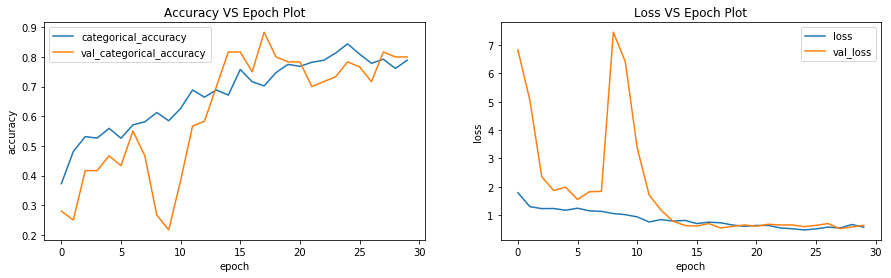

In [85]:
plot(history_model_5c)

## Model 6:- With BN in Convolution & Drop out in both FC layer

In [86]:
from keras.regularizers import l2
class Model6_Conv3D_FC_BN(ModelGenerator):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Flatten())
        
        model.add(Dense(dense_neurons,activation='relu',kernel_regularizer=l2(0.01)))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu', kernel_regularizer=l2(0.01)))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_Of_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 6A : With BN in Convolution & Drop out in both FC layer
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 30<br>
> Filter (3,3,3)

In [87]:
conv_3d_m6a=Model6_Conv3D_FC_BN()
conv_3d_m6a.image_size_initialize(image_height=100,image_width=100)
conv_3d_m6a.set_batch_epoch(batch_size=40,num_epochs=20)
conv_3d_model_6a=conv_3d_m6a.define_model(dropout=.5)
conv_3d_model_6a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_104 (Conv3D)          (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_104 (Activation)  (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_76 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_105 (Activation)  (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 7, 50, 50, 32)     128       
__________

In [88]:
print("Total Params:", conv_3d_model_6a.count_params())
history_model_6a = conv_3d_m6a.train_model(conv_3d_model_6a)

Total Params: 1476997
Epoch 1/20
17/17 [==============================] - 41s 2s/step - loss: 3.8856 - categorical_accuracy: 0.2910 - val_loss: 8.6274 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-05-2315_59_21.174922/model-00001-3.89137-0.28959-8.62737-0.32000.h5
Epoch 2/20
17/17 [==============================] - 12s 685ms/step - loss: 3.7079 - categorical_accuracy: 0.3274 - val_loss: 4.1883 - val_categorical_accuracy: 0.3333

Epoch 00002: saving model to model_init_2020-05-2315_59_21.174922/model-00002-3.70786-0.32737-4.18829-0.33333.h5
Epoch 3/20
17/17 [==============================] - 21s 1s/step - loss: 3.5676 - categorical_accuracy: 0.3253 - val_loss: 3.8581 - val_categorical_accuracy: 0.4167

Epoch 00003: saving model to model_init_2020-05-2315_59_21.174922/model-00003-3.57116-0.32425-3.85811-0.41667.h5
Epoch 4/20
17/17 [==============================] - 18s 1s/step - loss: 3.4312 - categorical_accuracy: 0.2972 - val_loss: 3.9886 - val_catego

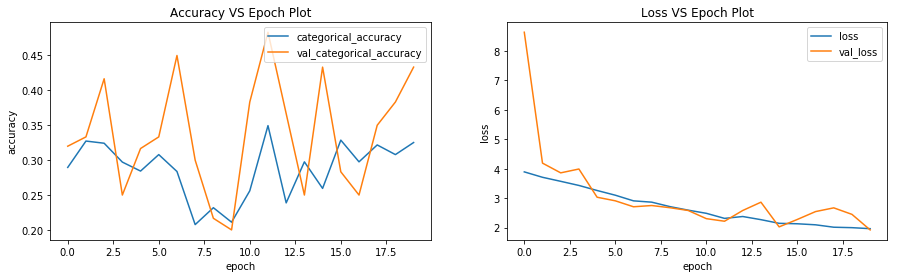

In [89]:
plot(history_model_6a)

## Model 7: CNN-RNN


In [90]:
class Model7_CNN_RNN_1(ModelGenerator):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
        #Flatten layer
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        #Softmax layer
        model.add(Dense(self.num_Of_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 7A :- CNN RNN
> Image size (120,120)<br>
> Batch Size 20<br>
> Epoch 20<br>
> LSTM Cells 128

In [91]:
rnn_cnn_m7a=Model7_CNN_RNN_1()
rnn_cnn_m7a.image_size_initialize(image_height=120,image_width=120)
rnn_cnn_m7a.set_batch_epoch(batch_size=20,num_epochs=20)
rnn_cnn_model_7a=rnn_cnn_m7a.define_model(lstm_cells=128,dense_neurons=64,dropout=0.25)
rnn_cnn_model_7a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 30, 30, 64)    18496     
__________

In [92]:
print("Total Params:", rnn_cnn_model_7a.count_params())
history_model_7a=rnn_cnn_m7a.train_model(rnn_cnn_model_7a,augment_data=True)

Total Params: 3384293
Epoch 1/20
34/34 [==============================] - 44s 1s/step - loss: 1.5690 - categorical_accuracy: 0.3149 - val_loss: 1.3442 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-05-2316_05_37.954627/model-00001-1.58066-0.30618-1.34424-0.53000.h5
Epoch 2/20
34/34 [==============================] - 5s 153ms/step - loss: 1.5480 - categorical_accuracy: 0.3333 - val_loss: 1.5136 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2020-05-2316_05_37.954627/model-00002-1.54802-0.33333-1.51364-0.27000.h5
Epoch 3/20
34/34 [==============================] - 8s 227ms/step - loss: 1.6539 - categorical_accuracy: 0.3039 - val_loss: 1.6397 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2020-05-2316_05_37.954627/model-00003-1.65392-0.30392-1.63973-0.25000.h5
Epoch 4/20
34/34 [==============================] - 8s 240ms/step - loss: 1.5684 - categorical_accuracy: 0.2549 - val_loss: 1.5688 - val_cat

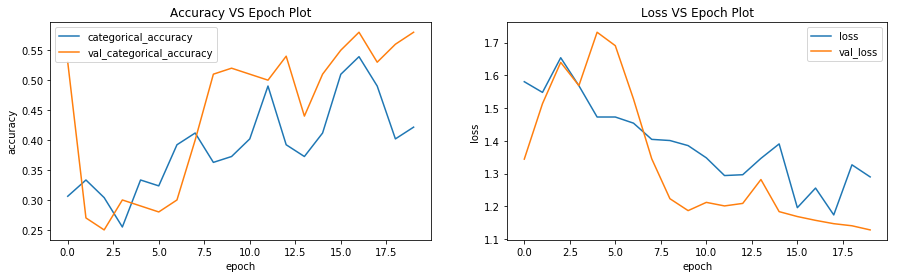

In [93]:
plot(history_model_7a)

## Model 7B :- CNN RNN
> Image size (120,120)<br>
> Batch Size 40<br>
> Epoch 40<br>
> Filter (3,3,3)

In [94]:
rnn_cnn_m7b=Model7_CNN_RNN_1()
rnn_cnn_m7b.image_size_initialize(image_height=120,image_width=120)
rnn_cnn_m7b.set_batch_epoch(batch_size=40,num_epochs=40)
rnn_cnn_model_7b=rnn_cnn_m7b.define_model(lstm_cells=128,dense_neurons=64,dropout=0.25)
rnn_cnn_model_7b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 30, 30, 64)    18496     
__________

In [95]:
print("Total Params:", rnn_cnn_model_7b.count_params())
history_model_7b=rnn_cnn_m7b.train_model(rnn_cnn_model_7b,augment_data=True)

Total Params: 3384293
Epoch 1/40
17/17 [==============================] - 45s 3s/step - loss: 1.5480 - categorical_accuracy: 0.2816 - val_loss: 1.4738 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-05-2316_09_15.169911/model-00001-1.54818-0.28205-1.47376-0.34000.h5
Epoch 2/40
17/17 [==============================] - 12s 701ms/step - loss: 1.3594 - categorical_accuracy: 0.4399 - val_loss: 1.4723 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-05-2316_09_15.169911/model-00002-1.35939-0.43990-1.47232-0.30000.h5
Epoch 3/40
17/17 [==============================] - 21s 1s/step - loss: 1.3722 - categorical_accuracy: 0.4392 - val_loss: 1.2776 - val_categorical_accuracy: 0.4667

Epoch 00003: saving model to model_init_2020-05-2316_09_15.169911/model-00003-1.37863-0.43597-1.27765-0.46667.h5
Epoch 4/40
17/17 [==============================] - 19s 1s/step - loss: 1.1956 - categorical_accuracy: 0.4551 - val_loss: 1.3117 - val_catego

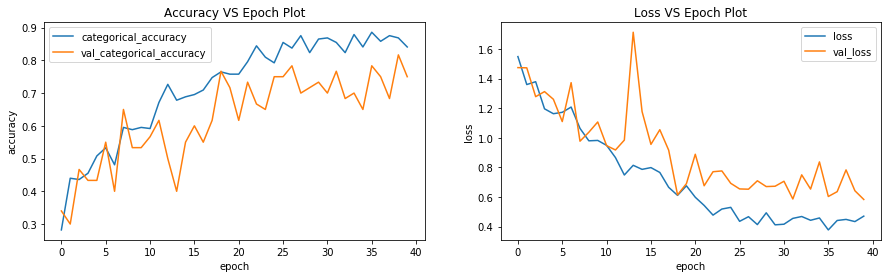

In [96]:
plot(history_model_7b)

## Model 7C :- CNN RNN
> Image size (100,100)<br>
> Batch Size 40<br>
> Epoch 40<br>
> dropout .45

In [97]:
rnn_cnn_m7c=Model7_CNN_RNN_1()
rnn_cnn_m7c.image_size_initialize(image_height=100,image_width=100)
rnn_cnn_m7c.set_batch_epoch(batch_size=40,num_epochs=40)
rnn_cnn_model_7c=rnn_cnn_m7c.define_model(lstm_cells=128,dense_neurons=64,dropout=0.45)
rnn_cnn_model_7c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 25, 25, 64)    18496     
__________

In [98]:
print("Total Params:", rnn_cnn_model_7c.count_params())
history_model_7c=rnn_cnn_m7c.train_model(rnn_cnn_model_7c,augment_data=True)

Total Params: 2532325
Epoch 1/40
17/17 [==============================] - 44s 3s/step - loss: 1.6986 - categorical_accuracy: 0.2449 - val_loss: 1.5011 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-05-2316_21_34.897183/model-00001-1.70077-0.24133-1.50106-0.50000.h5
Epoch 2/40
17/17 [==============================] - 10s 606ms/step - loss: 1.6099 - categorical_accuracy: 0.2558 - val_loss: 1.4850 - val_categorical_accuracy: 0.4333

Epoch 00002: saving model to model_init_2020-05-2316_21_34.897183/model-00002-1.60994-0.25575-1.48504-0.43333.h5
Epoch 3/40
17/17 [==============================] - 22s 1s/step - loss: 1.5174 - categorical_accuracy: 0.3088 - val_loss: 1.4860 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2020-05-2316_21_34.897183/model-00003-1.52080-0.30518-1.48595-0.35000.h5
Epoch 4/40
17/17 [==============================] - 18s 1s/step - loss: 1.4554 - categorical_accuracy: 0.3313 - val_loss: 1.4783 - val_catego


Epoch 00029: saving model to model_init_2020-05-2316_21_34.897183/model-00029-1.04422-0.54325-0.91115-0.66667.h5
Epoch 30/40
17/17 [==============================] - 17s 999ms/step - loss: 0.9989 - categorical_accuracy: 0.5882 - val_loss: 1.0336 - val_categorical_accuracy: 0.6000

Epoch 00030: saving model to model_init_2020-05-2316_21_34.897183/model-00030-0.99886-0.58824-1.03359-0.60000.h5
Epoch 31/40
17/17 [==============================] - 17s 1s/step - loss: 1.0541 - categorical_accuracy: 0.5779 - val_loss: 0.9519 - val_categorical_accuracy: 0.6333

Epoch 00031: saving model to model_init_2020-05-2316_21_34.897183/model-00031-1.05408-0.57785-0.95192-0.63333.h5
Epoch 32/40
17/17 [==============================] - 16s 958ms/step - loss: 0.9927 - categorical_accuracy: 0.6228 - val_loss: 0.9230 - val_categorical_accuracy: 0.6167

Epoch 00032: saving model to model_init_2020-05-2316_21_34.897183/model-00032-0.99273-0.62284-0.92303-0.61667.h5
Epoch 33/40
17/17 [========================

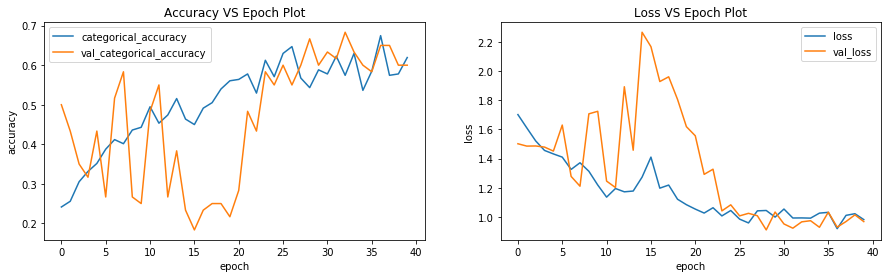

In [99]:
plot(history_model_7c)

# Model 8 : CNN LSTM with GRU

In [19]:
class Model8_CNN_RNN_2(ModelGenerator):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(15,self.image_height,self.image_width,self.num_Of_channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_Of_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn_m8=Model8_CNN_RNN_2()
rnn_cnn_m8.image_size_initialize(image_height=120,image_width=120)
rnn_cnn_m8.set_batch_epoch(batch_size=40,num_epochs=20)
rnn_cnn_model_m8=rnn_cnn_m8.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_model_m8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 30, 30, 64)    18496     
__________

In [22]:
print("Total Params:", rnn_cnn_model_m8.count_params())
history_model_m8=rnn_cnn_m8.train_model(rnn_cnn_model_m8,augment_data=True)

Total Params: 2573541
Epoch 1/20
17/17 [==============================] - 140s 8s/step - loss: 1.6263 - categorical_accuracy: 0.2985 - val_loss: 1.3295 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-05-2516_32_28.757103/model-00001-1.63385-0.29412-1.32951-0.43000.h5
Epoch 2/20
17/17 [==============================] - 23s 1s/step - loss: 1.0954 - categorical_accuracy: 0.5780 - val_loss: 1.1175 - val_categorical_accuracy: 0.5833

Epoch 00002: saving model to model_init_2020-05-2516_32_28.757103/model-00002-1.09540-0.57801-1.11748-0.58333.h5
Epoch 3/20
17/17 [==============================] - 22s 1s/step - loss: 0.9907 - categorical_accuracy: 0.6008 - val_loss: 1.0256 - val_categorical_accuracy: 0.5333

Epoch 00003: saving model to model_init_2020-05-2516_32_28.757103/model-00003-0.99819-0.59401-1.02561-0.53333.h5
Epoch 4/20
17/17 [==============================] - 19s 1s/step - loss: 0.8129 - categorical_accuracy: 0.7059 - val_loss: 0.9660 - val_categori

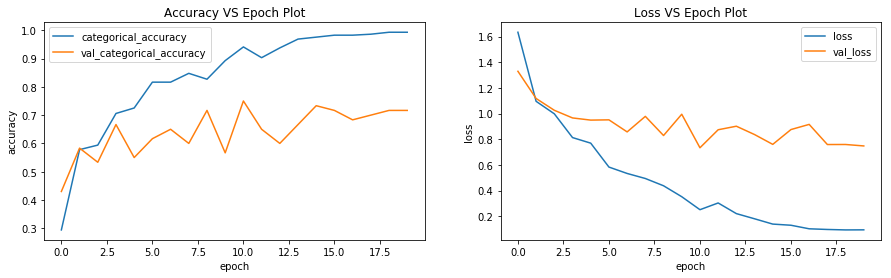

In [23]:
plot(history_model_m8)